Create a forward operator and display sensitivity maps
======================================================

`
Authors: Eric Larson <larson.eric.d@gmail.com>
         Denis Engemann <denis.engemann@gmail.com>
         Alex Gramfort <alexandre.gramfort@telecom-paristech.fr>
`

License: BSD (3-clause)

First setup some paths. We will use the MNE sample data.

In [1]:
import mne
from mne.datasets import sample
data_path = sample.data_path()

# the raw file containing the channel location + types
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
# The transformation file obtained by coregistration
mri = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'
# The source space obtained with
# mne_setup_source_space --ico -6
src = data_path + '/subjects/sample/bem/sample-oct-6-src.fif'
# The BEM file (LHS in Poission's equation...) obtained with
# mne_setup_forward_model --surf --ico 4
bem = data_path + '/subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif'
# Name of the forward to read or compute
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
# The paths to freesurfer reconstructions
subjects_dir = data_path + '/subjects'

In [2]:
from IPython.display import Image
from mayavi import mlab

In [41]:
# src = mne.setup_source_space('sample', spacing='oct6', subjects_dir=subjects_dir)

**Remark:** Since MNE-Python 0.7 you can compute the source space in Python with something like

In [3]:
mne.set_log_level('WARNING')

# Are our bem meshes ok?

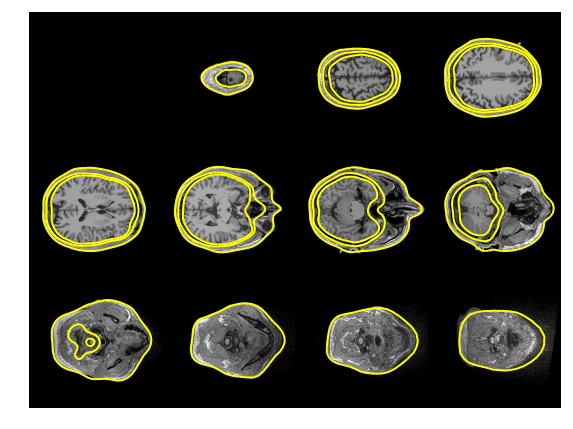

In [4]:
%matplotlib inline
mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir, orientation='axial');

# Is our coregistration ok?

Compute the forward solution

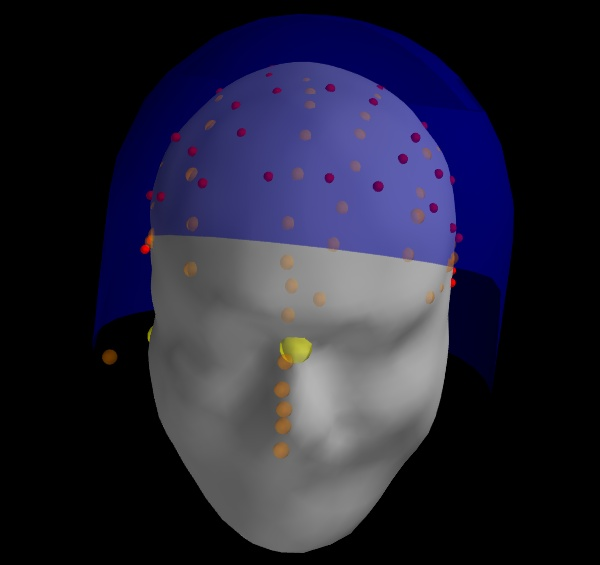

In [9]:
info = mne.io.read_info(raw_fname)

fig = mne.viz.plot_trans(info, mri, subject='sample', dig=True,
                         subjects_dir=subjects_dir);
mlab.savefig('coreg.jpg')
Image(filename='coreg.jpg', width=500)

In [12]:
fwd = mne.make_forward_solution(raw_fname, trans=mri, src=src, bem=bem,
                                fname=None, # don't save it to disk
                                meg=True, # include MEG channels
                                eeg=True, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=8) # number of jobs to run in parallel

Convert to surface orientation for cortically constrained inverse modeling

In [14]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
leadfield = fwd['sol']['data']
print "Leadfield size : %d sensors x %d dipoles" % leadfield.shape

Leadfield size : 366 sensors x 22494 dipoles


Or read it from disk

In [47]:
# fwd = mne.read_forward_solution(fwd_fname, surf_ori=True)

notebook inline plotting

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

Compute sensitivity maps

In [16]:
grad_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')
mag_map = mne.sensitivity_map(fwd, ch_type='mag', mode='fixed')
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')

# Show gain matrix a.k.a. leadfield matrix with sensitivy map

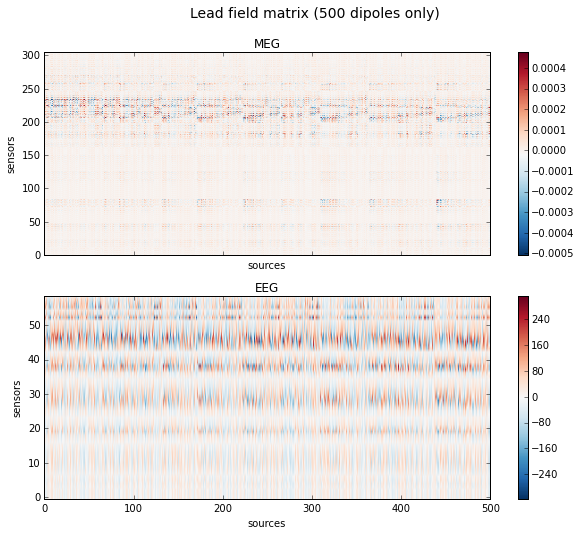

In [18]:
picks_meg = mne.pick_types(fwd['info'], meg=True, eeg=False)
picks_eeg = mne.pick_types(fwd['info'], meg=False, eeg=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  
fig.suptitle('Lead field matrix (500 dipoles only)', fontsize=14)

for ax, picks, ch_type in zip(axes, [picks_meg, picks_eeg], ['meg', 'eeg']):

   im = ax.imshow(leadfield[picks, :500], origin='lower', aspect='auto', cmap='RdBu_r')
   ax.set_title(ch_type.upper())
   ax.set_xlabel('sources')
   ax.set_ylabel('sensors')
   plt.colorbar(im, ax=ax, cmap='RdBu_r')


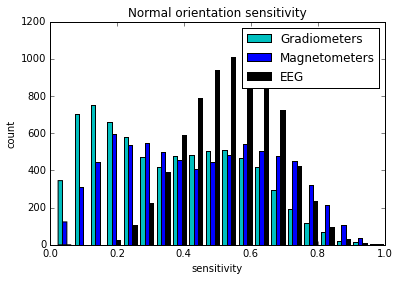

In [19]:
plt.hist([grad_map.data.ravel(), mag_map.data.ravel(), eeg_map.data.ravel()],
         bins=20, label=['Gradiometers', 'Magnetometers', 'EEG'], color=['c', 'b', 'k'])
plt.legend()
plt.title('Normal orientation sensitivity')
plt.xlabel('sensitivity')
plt.ylabel('count');

In [24]:
# enable correct backend for 3d plotting
%matplotlib qt4
clim = dict(kind='value', lims=(0.0, 0.5, 1.0), smoothing_steps=3)  # let's see single dipoles
brain = mag_map.plot(subject='sample', time_label='Magnetometer sensitivity',
                     subjects_dir=subjects_dir, clim=clim);

Updating smoothing matrix, be patient..


INFO:surfer:Updating smoothing matrix, be patient..


Smoothing matrix creation, step 1


INFO:surfer:Smoothing matrix creation, step 1


Smoothing matrix creation, step 2


INFO:surfer:Smoothing matrix creation, step 2


Smoothing matrix creation, step 3


INFO:surfer:Smoothing matrix creation, step 3


Smoothing matrix creation, step 4


INFO:surfer:Smoothing matrix creation, step 4


Smoothing matrix creation, step 5


INFO:surfer:Smoothing matrix creation, step 5


Smoothing matrix creation, step 6


INFO:surfer:Smoothing matrix creation, step 6


Smoothing matrix creation, step 7


INFO:surfer:Smoothing matrix creation, step 7


Smoothing matrix creation, step 8


INFO:surfer:Smoothing matrix creation, step 8


Smoothing matrix creation, step 9


INFO:surfer:Smoothing matrix creation, step 9


Smoothing matrix creation, step 10


INFO:surfer:Smoothing matrix creation, step 10


colormap: fmin=0.00e+00 fmid=5.00e-01 fmax=1.00e+00 transparent=1


INFO:surfer:colormap: fmin=0.00e+00 fmid=5.00e-01 fmax=1.00e+00 transparent=1


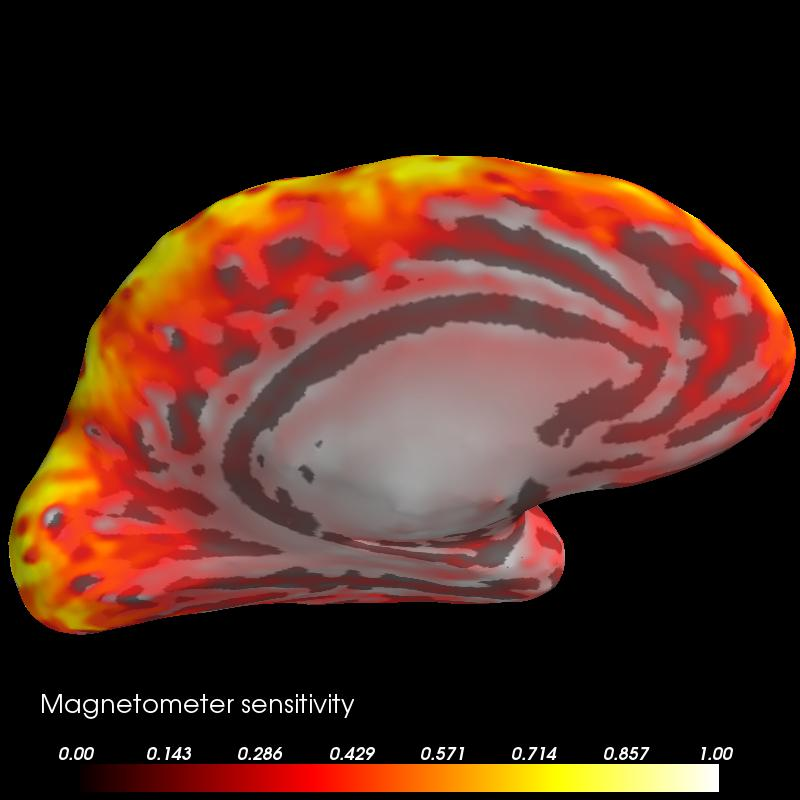

In [25]:
view = 'med'
brain.show_view(view)
brain.save_image('sensitivity_map_%s.jpg' % view)
Image(filename='sensitivity_map_%s.jpg' % view, width=400)

## Exercise

Plot the sensitivity maps for EEG and compare it with the MEG, can you justify the claims that:

- MEG is not sensitive to radial sources
- EEG is more sensitive to deep sources

How will the MEG sensitivity maps and histograms change if you use a free instead if a fixed orientation?

Try this changing the `mode` parameter in `mne.sensitivity_map` accordingly.

Why don't we see any dipoles on the gyri?

# Visualizing field lines based on coregistration

In [26]:
# read in data

from mne import read_evokeds
from mne.datasets import sample
from mne import make_field_map

data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
trans_fname = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

In [27]:
# If trans_fname is set to None then only MEG estimates can be visualized

condition = 'Left Auditory'
evoked = read_evokeds(evoked_fname, condition=condition, baseline=(-0.2, 0.0))

# Compute the field maps to project MEG and EEG data to MEG helmet
# and scalp surface
maps = make_field_map(evoked, trans=trans_fname, subject='sample',
                      subjects_dir=subjects_dir, n_jobs=1)

# explore several points in time
field_map = evoked.plot_field(maps, time=.1);

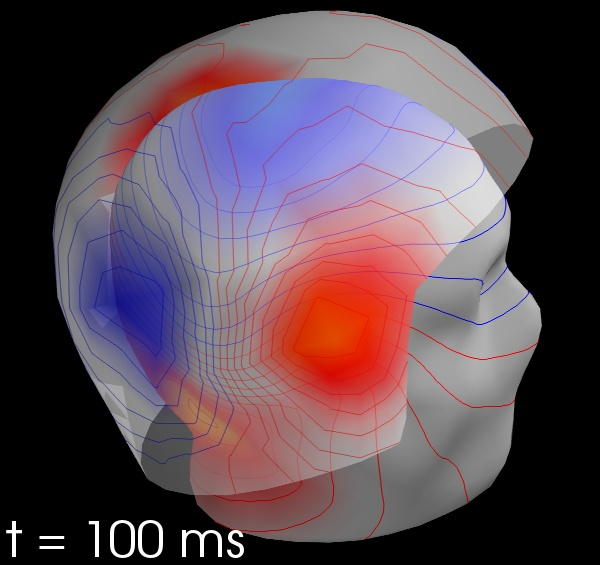

In [28]:
from mayavi import mlab
mlab.savefig('field_map.jpg', figure=field_map)
from IPython.display import Image
Image(filename='field_map.jpg', width=800)